## Kinetic Monte-Carlo

In [54]:
import numpy                as np
import matplotlib.pyplot    as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
import scipy.constants      as cst
import random

In [30]:
"CONSTANTES"
kB = cst.physical_constants['Boltzmann constant'][0]
eV = cst.physical_constants['electron volt'][0]
h  = cst.physical_constants['Planck constant'][0]

In [121]:
"PARAMETRES"
T  = 800       # Température (K)
ES = 1.3 * eV  # Energie atome-substrat (eV)
EN = 1.0 * eV  # Energie atome-voisin (eV)
L  = 200       # Nombre d'atomes sur une ligne de la grille
theta = 0.05    # Coverage

"PROBABILITES"
F  = 0.1                # Nombre d'atomes déposés sur une colonne par seconde
t_dep = 1 / (F * L**2)  # Intervalle de temps entre deux dépôts sur la grille de L^2 atomes

D  = (2*kB*T/h) * np.exp(-ES/(kB*T))  # Nombre de sauts effectués par un atome (sans voisins) par seconde
t_diff = 1 / D                        # Intervalle de temps entre deux sauts pour un atome sans voisins

# Poids de la constante de vitesse dû aux voisins:
p0 = 1
p1 = np.exp(-1*EN/(kB*T))
p2 = np.exp(-2*EN/(kB*T))
p3 = np.exp(-3*EN/(kB*T))
p4 = np.exp(-4*EN/(kB*T))
P  = [p0, p1, p2, p3, p4]  # P[n] est la probabilité à utiliser pour n voisins
print(P)

[1, 5.01504841526016e-07, 2.5150710607403444e-13, 1.2613203137432464e-19, 6.32558244057356e-26]


In [124]:
"Ajout d'un atome sur la colonne (i, j)"
def add_atom(i,j):
    
    C_ini = int(Classe[i,j])
    Types[C_ini].remove( (i, j) ) # retirer la colonne de la table de classes
    
    # Si le nouvel atome va dépasser ses voisins, baisser la classe de la colonne:
    if H[i,j] == H[np.mod(i-1,L), j]:
        Classe[i,j] -= 1
    if H[i,j] == H[np.mod(i+1,L), j]:
        Classe[i,j] -= 1
    if H[i,j] == H[i, np.mod(j-1,L)]:
        Classe[i,j] -= 1
    if H[i,j] == H[i, np.mod(j+1,L)]:
        Classe[i,j] -= 1
        
    C_fin = int(Classe[i,j])
    Types[C_fin].append( (i, j) ) # ajouter la colonne à la table de classes
        
    H[i,j] += 1  # ajouter l'atome en (i, j)
        
    # Si le nouvel atome change la classe des colonnes voisines:
    if H[i,j] == H[np.mod(i-1,L), j]:
        
        C = int(Classe[np.mod(i-1,L), j])
        Types[C].remove( (np.mod(i-1,L), j) )
        Classe[np.mod(i-1,L),j] += 1
        Types[C+1].append( (np.mod(i-1,L), j) )
        
    if H[i,j] == H[np.mod(i+1,L), j]:
        
        C = int(Classe[np.mod(i+1,L), j])
        Types[C].remove( (np.mod(i+1,L), j) )
        Classe[np.mod(i+1,L),j] += 1
        Types[C+1].append( (np.mod(i+1,L), j) )
        
    if H[i,j] == H[i, np.mod(j-1,L)]:
        
        C = int(Classe[i, np.mod(j-1,L)])
        Types[C].remove( (i, np.mod(j-1,L)) )
        Classe[i,np.mod(j-1,L)] += 1
        Types[C+1].append( (i, np.mod(j-1,L)) )
        
    if H[i,j] == H[i, np.mod(j+1,L)]:
        
        C = int(Classe[i, np.mod(j+1,L)])
        Types[C].remove( (i, np.mod(j+1,L)) )
        Classe[i,np.mod(j+1,L)] += 1
        Types[C+1].append( (i, np.mod(j+1,L)) )


"Suppression d'un atome sur la colonne (i, j)"        
def remove_atom(i,j):
    
    # Si la suppression change la classe des colonnes voisines:
    if H[i,j] == H[np.mod(i-1,L), j]:
        
        C = int(Classe[np.mod(i-1,L), j])
        Types[C].remove( (np.mod(i-1,L), j) )
        Classe[np.mod(i-1,L),j] -= 1
        Types[C-1].append( (np.mod(i-1,L), j) )
        
    if H[i,j] == H[np.mod(i+1,L), j]:
        
        C = int(Classe[np.mod(i+1,L), j])
        Types[C].remove( (np.mod(i+1,L), j) )
        Classe[np.mod(i+1,L),j] -= 1
        Types[C-1].append( (np.mod(i+1,L), j) )
        
    if H[i,j] == H[i, np.mod(j-1,L)]:
        
        C = int(Classe[i, np.mod(j-1,L)])
        Types[C].remove( (i, np.mod(j-1,L)) )
        Classe[i,np.mod(j-1,L)] -= 1
        Types[C-1].append( (i, np.mod(j-1,L)) )
        
    if H[i,j] == H[i, np.mod(j+1,L)]:
        
        C = int(Classe[i, np.mod(j+1,L)])
        Types[C].remove( (i, np.mod(j+1,L)) )
        Classe[i,np.mod(j+1,L)] -= 1
        Types[C-1].append( (i, np.mod(j+1,L)) )
        
    H[i,j] -= 1  # supprimer l'atome en (i, j)
    
    C_ini = int(Classe[i,j])
    Types[C_ini].remove( (i, j) )
        
    # Si le nouvel atome gagne des voisins, augmenter sa classe:
    if H[i,j] == H[np.mod(i-1,L), j]:
        Classe[i,j] += 1
    if H[i,j] == H[np.mod(i+1,L), j]:
        Classe[i,j] += 1
    if H[i,j] == H[i, np.mod(j-1,L)]:
        Classe[i,j] += 1
    if H[i,j] == H[i, np.mod(j+1,L)]:
        Classe[i,j] += 1
        
    C_fin = int(Classe[i,j])
    Types[C_fin].append( (i, j) )


"Kinetic Monte Carlo"
def KMC():
    s=0
    'Deposition'
    for S in range(0, n_dep):

        I, J = np.random.randint(L, size=2) # on choisit au hasard une colonne (I, J) sur la grille
        add_atom(I, J)                      # on y ajoute un atome
        
        if ((S+1) % 10) == 0: # Suivre l'avancée du calcul
            print('Atomes déposés: '+str(S+1))

        'Diffusion'
        t = 0             # reset le compteur de temps
        #print(s)
        s=0
        while t < t_dep:  # On diffuse pendant le temps t_dep avant la nouvelle déposition
            s=s+1

            N = L**2 - len(Types[4]) - len(Types[3]) - len(Types[2]) # Nombre d'atomes qui peuvent bouger (P[n] non négligeable)
            #print(N)
            t += t_diff/N # Ajout de l'intervalle de temps pour 1 saut pour le nombre d'atomes mobiles considéré

            i, j = random.choice(Types[0]+Types[1]) # on choisit au hasard un atome mobile
            C = int(Classe[i, j])                            # on lit la classe de l'atome choisi

            
            if (C > 4) or (C < 0):  # Vérifier que la classe n'est pas aberrante
                print('ERREUR: Classe impossible !!')
                print(C)
            

            p = P[C]    # probabilité d'accepter le saut pour la classe de l'atome choisi
            
            r = np.random.rand()
            if r < p: # si le saut est accepté

                # On déplace l'atome selon l'une des quatres directions:
                r2 = np.random.rand()
                remove_atom(i, j)
                if r2 < 0.25:
                        add_atom(np.mod(i-1, L), j)
                if 0.25 < r2 < 0.50:
                        add_atom(np.mod(i+1, L), j)
                if 0.50 < r2 < 0.75:
                        add_atom(i, np.mod(j-1, L))
                if 0.75 < r2 < 1:
                        add_atom(i, np.mod(j+1, L))
                        
                # A ajouter: condition sur la différence de hauteur entre les colonnes de départ et d'arrivée
                
                

In [125]:
"SIMULATION"

"Nombre total d'atomes à déposer"
n_dep = int(L**2*theta)
print('Atomes à déposer: '+str(n_dep))

'Matrice H initiale: 0 atomes partout'
H = np.ones((L,L)) * 0

'Matrice des classes initiale: 4 voisins partout'
Classe = np.ones((L,L)) * 4

'Liste des types initiale: toutes les coordonnées (i, j) dans Types[4]'
Columns = []
for i in range(0, L):
    for j in range(0, L):
        Columns.append((i, j))
Types = [[], [], [], [], Columns]  # Liste des colonnes (i, j) de classe 0, 1, 2, 3, 4

'Lancer la simulation Monte-Carlo'
KMC()

Atomes à déposer: 2000
Atomes déposés: 10
Atomes déposés: 20
Atomes déposés: 30
Atomes déposés: 40
Atomes déposés: 50
Atomes déposés: 60
Atomes déposés: 70
Atomes déposés: 80
Atomes déposés: 90
Atomes déposés: 100
Atomes déposés: 110
Atomes déposés: 120
Atomes déposés: 130
Atomes déposés: 140
Atomes déposés: 150
Atomes déposés: 160
Atomes déposés: 170
Atomes déposés: 180
Atomes déposés: 190
Atomes déposés: 200
Atomes déposés: 210
Atomes déposés: 220
Atomes déposés: 230
Atomes déposés: 240
Atomes déposés: 250
Atomes déposés: 260
Atomes déposés: 270
Atomes déposés: 280
Atomes déposés: 290
Atomes déposés: 300
Atomes déposés: 310
Atomes déposés: 320
Atomes déposés: 330
Atomes déposés: 340
Atomes déposés: 350
Atomes déposés: 360
Atomes déposés: 370
Atomes déposés: 380
Atomes déposés: 390
Atomes déposés: 400
Atomes déposés: 410
Atomes déposés: 420
Atomes déposés: 430
Atomes déposés: 440
Atomes déposés: 450
Atomes déposés: 460
Atomes déposés: 470
Atomes déposés: 480
Atomes déposés: 490
Atomes

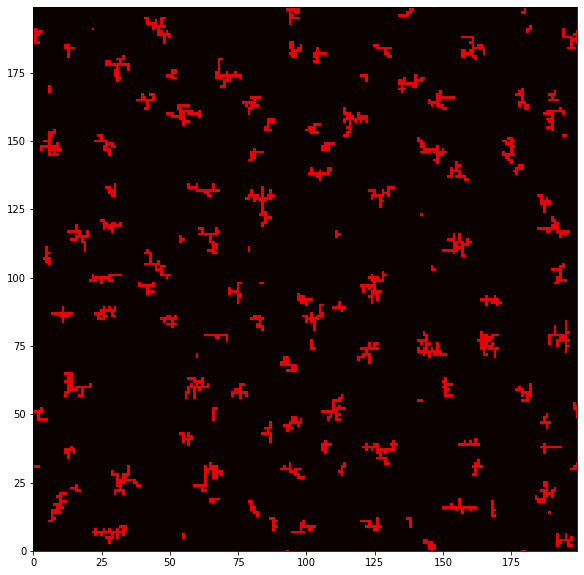

In [126]:
"RESULTATS"

np.savetxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(EN/eV)+'.txt', H)

'Tracer la surface en 2D'
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(H, cmap='hot', vmax=3, vmin=0)

ax.set_xlim(0,L-1)
ax.set_ylim(0,L-1)

plt.show()

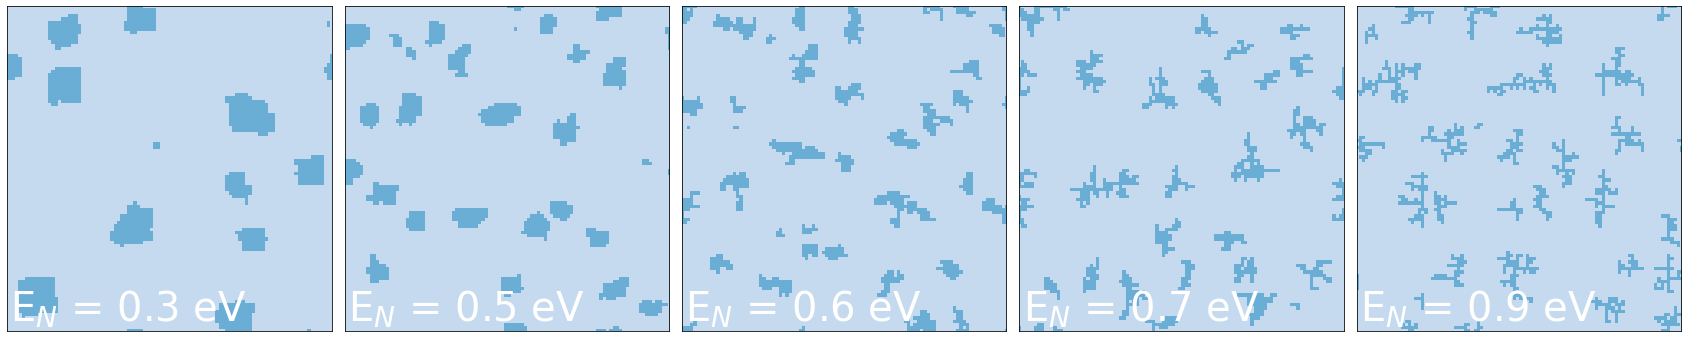

In [84]:
"COMPARAISON"

'Tracer la surface en 2D'
%matplotlib inline
fig, ax = plt.subplots(1, 5, figsize=(30,150))
fig.subplots_adjust(wspace=0.04)

Elist = [0.3,0.5,0.6,0.7,0.9]

for i in range(0,len(Elist)):
    E = Elist[i]
    HH = np.loadtxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(E)+'.txt')
    ax[i].imshow(HH, cmap='Blues', vmax=3, vmin=-1)

    ax[i].set_xlim(0,L-1)
    ax[i].set_ylim(0,L-1)
    
    ax[i].text(1, 3, r'E$_N$ = '+str(E)+' eV',fontsize=40,color='white')
    
    ax[i].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax[i].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.show()

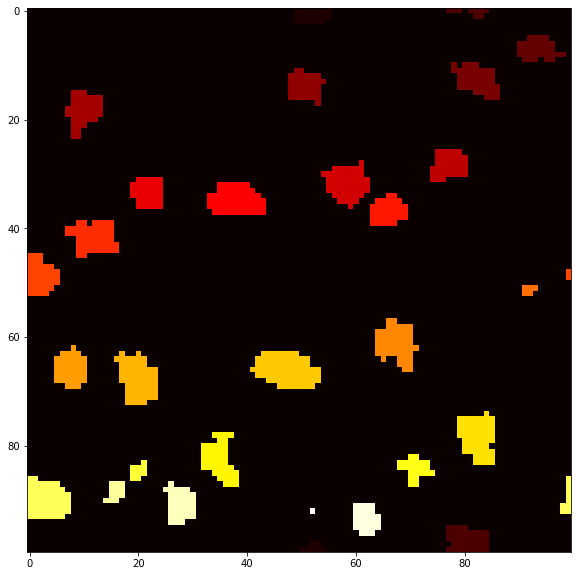

In [164]:
"CONNECTED COMPONENT ANALYSIS"

from scipy.ndimage.measurements import label

test = np.loadtxt('L=100F=0.1T=800theta=0.1EN=0.5.txt')

graph = np.where(test > 0,1,0) # graphe des ilôts: 1 si h>0, 0 sinon

structure = [[0,1,0],[1,1,1],[0,1,0]]  # connection filter: les atomes doivent se toucher par une arête !

'Trouver les composantes connexes'
label_image, ncomponents = label(graph, structure)

'Appliquer les conditions périodiques'
for y in range(label_image.shape[0]):
    if label_image[y, 0] > 0 and label_image[y, -1] > 0:
        label_image[label_image == label_image[y, -1]] = label_image[y, 0]
for x in range(label_image.shape[1]):
    if label_image[0, x] > 0 and label_image[-1, x] > 0:
        label_image[label_image == label_image[-1, x]] = label_image[0, x]
        
        
'Tracer les composantes connexes'
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(label_image, cmap='hot', vmax=np.max(label_image), vmin=0)

plt.show()




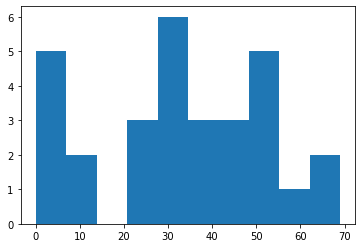

In [165]:
"Distribution des tailles d'ilôts"
orders = []
for compo in range(1, np.max(label_image)+1):
    order = np.sum(np.where(label_image==compo,1,0))
    orders.append(order)
    
mean = np.mean(orders)

normorders = orders/mean
    
plt.hist(orders,bins=10)
plt.show()